In [19]:
import pandas as pd

In [20]:
df = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/final_labels.csv', index_col=0)

In [21]:
df

,External ID,Dehumanization,Emotion,Mention,Created By,text,rating
0,row_0.txt,так,"так, присутня негативна",так,snizannabotvin@gmail.com,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",4
1,row_1.txt,ні,"ні, оцінка не присутня",ні,snizannabotvin@gmail.com,Литературный критик Галина Юзефович о новом ро...,4
2,row_10.txt,так,"так, присутня негативна",так,snizannabotvin@gmail.com,Почему на базах неонацистов стоят языческие ис...,4
3,row_100.txt,так,"так, присутня негативна",так,snizannabotvin@gmail.com,Группа добровольцев-медиков из Чеченской Респу...,4
1441,row_1000.txt,ні,"ні, оцінка не присутня",так,tutovadesign@gmail.com,"ВСУшники, переходите на сторону добра, у нас т...",5
...,...,...,...,...,...,...,...
2638,row_995.txt,ні,"ні, оцінка не присутня",так,tutovadesign@gmail.com,Утренний брифинг Минобороны России: ▪️ россий...,5
2639,row_996.txt,ні,"так, присутня негативна",так,tutovadesign@gmail.com,И понеслась мазепинщино-петлюровщино-бандеровщ...,5
2760,row_997.txt,ні,"так, присутня негативна",так,yevhen.marchenko91@gmail.com,Наш соратник по русскому движению Алексей Сели...,3
2761,row_998.txt,так,"ні, оцінка не присутня",так,yevhen.marchenko91@gmail.com,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,3


In [22]:
df_dehumanization = df[['Dehumanization', 'text']].reset_index(drop=True)

In [23]:
df_dehumanization['label'] = df_dehumanization['Dehumanization'].apply(lambda x: 0 if x=='ні' else 1)

In [24]:
df_dehumanization

,Dehumanization,text,label
0,так,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",1
1,ні,Литературный критик Галина Юзефович о новом ро...,0
2,так,Почему на базах неонацистов стоят языческие ис...,1
3,так,Группа добровольцев-медиков из Чеченской Респу...,1
4,ні,"ВСУшники, переходите на сторону добра, у нас т...",0
...,...,...,...
3541,ні,Утренний брифинг Минобороны России: ▪️ россий...,0
3542,ні,И понеслась мазепинщино-петлюровщино-бандеровщ...,0
3543,ні,Наш соратник по русскому движению Алексей Сели...,0
3544,так,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,1


## Preprocessing

In [25]:
import spacy
nlp = spacy.load('ru_core_news_md',disable=['ner', 'attribute_ruler'])

def lemmatize_spacy(text):
    doc = nlp(text)
    result = " ".join([token.lemma_ for token in doc])
    return result

In [26]:
cyrillic_letters = u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ "

def clean_text(string, allowed_symbols):
    getVals = list(filter(lambda x: x in allowed_symbols, string))
    result = "".join(getVals)
    return result

In [27]:
def preprocess_df(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))
    df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))
    df=df[df['text_clean']!='']
    df.reset_index(inplace=True)
    return df

In [28]:
%%time
df_dehumanization = preprocess_df(df_dehumanization)

CPU times: user 17.8 s, sys: 187 ms, total: 18 s
Wall time: 18.1 s


## Logreg

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_, X_test_, y_train, y_test = train_test_split(df_dehumanization["text_clean"], df_dehumanization["label"], test_size=0.2, random_state=42)

In [45]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_)
X_test = vectorizer.transform(X_test_)

In [32]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.80
Precision: 0.81
Recall: 0.71
F1 Score: 0.76


### Gridsearch

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

logreg_best = grid_search.best_estimator_

logreg_best.fit(X_train, y_train)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [35]:
y_pred = logreg_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.79
Recall: 0.77
F1 Score: 0.78


In [36]:
best_params = logreg_best.get_params()
print("Best hyperparameters for the logistic regression model:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: None
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


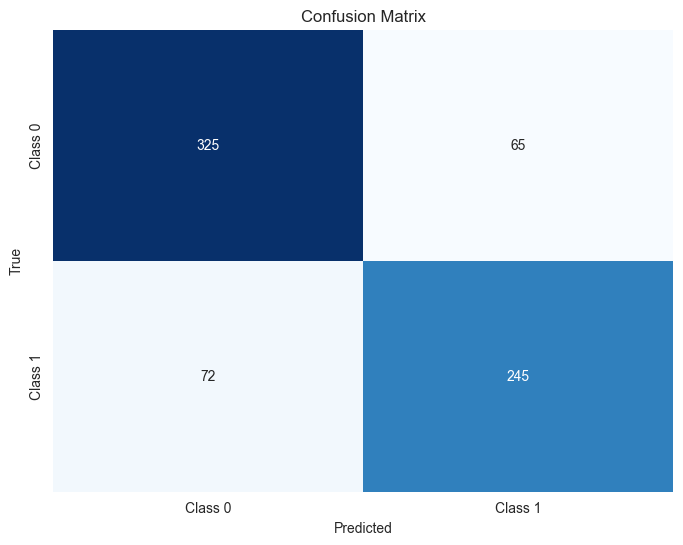

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:
original_data = df_dehumanization.loc[X_test_.index]

In [47]:
original_data['Predicted Label'] = y_pred
original_data['Prediction Status'] = original_data['label'] == original_data['Predicted Label']
incorrect_predictions = original_data[~original_data['Prediction Status']]

In [48]:
print("Incorrectly predicted samples:")
for index, row in incorrect_predictions.iterrows():
    print(f"Index: {index}\nOriginal Text: {row['text']}\nTrue Label: {row['label']}\nPredicted Label: {row['Predicted Label']}\n")

Incorrectly predicted samples:
Index: 2412
Original Text: Половцы и печенеги только о себе думают;)
True Label: 0
Predicted Label: 1

Index: 495
Original Text: "Вот так мы живэм! Вот так нас кинули, а сами поехали в Запорожье"  У укровояки накипело.
True Label: 1
Predicted Label: 0

Index: 2562
Original Text: А какие это ваши условия? Сложите оружие, отдайте границу, все в тюрьму, мы введём свою администрацию из галичан, всех вас через фильтрационный лагерь, Бандеру в каждый дом, и жизни вас научим?   Вы там реально все примороженные? Вы реально думаете, что в ЛДНР все мечтают извиниться перед вами, покаяться и принять господина галичанского?   Так они того же от вас ждут! Опустите себя на землю и договоравайтесь с Донецком и Луганском как с равными себе!  А то им не мир нужен, а мир на их условиях.
True Label: 1
Predicted Label: 0

Index: 2210
Original Text: Молодежь Херсона продолжает напоминать свидомым, ожидающим возвращения "пана" Зеленского и его шайки, что Херсон — это Русский г

### Preliminary error analysis

Укрвояки сприймається системою як дегуманізація

Рядок 2562, 2210, 1288, 1188, 291, 2486 - сумнівний лейбл, цілком можливо що система права

Хохлофейки тригерить систему

Чомусь тригерить коронавірус (93, 33)

Не впізнає місцями свинорейх (як в 3419, 170)

Майже весь неонацизм постійно тригерить систему - 2775, 1011, 289 (але от в 2320 - неонацизм как раковая опухоль - ні, 3193 - )

1070 - система тригериться на чубатих

Система гірше зчитує subtle cues - 554 (накапливаются), 2335 (зондероотряд), 486 (не бандероукропианці, а держава = навоз), 2646 (опис а не фразеологізм)

Не всі атрибути нацизма впізнає - 678 (бандерюгенд), 2335 (зондероотряд), 2293 (бандерофашисти)

2086 - укропские мартішки


